Import libraries

In [3]:
import os

import pandas as pd

import numpy as np

from sklearn import preprocessing

from scipy import stats
import scipy.stats as sc
from scipy.cluster.hierarchy import linkage,leaves_list

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

Import data

In [5]:
dataFolderName = '../data_luc/video/'

listVideoName =   ['x264-1908-bridgefar-wasm/x264-results1.csv', 
                   'x264-1908-ice-wasm/x264-results1.csv',
                   'x264-1908-flower-wasm/x264-results1.csv', 
                   'x264-1908-caire-wasm/x264-results1.csv',
                   'x264-0208-sintel-calda-wasm/x264-results1.csv', 
                   'x264-1908-footballcif-wasm/x264-results1.csv',
                   'x264-0308-crowd_run-wasm/x264-results1.csv', 
                   'x264-0608-blue-wasm/x264-results1.csv',
                   'x264-0608-people-wasm/x264-results1.csv', 
                   'x264-1908-sunflowers-wasm/x264-results1.csv',
                   'x264-0408-deadline-wasm/x264-results1.csv', 
                   'x264-2108-bridgeclose-wasm/x264-results1.csv',
                   'x264-1908-husky-wasm/x264-results1.csv', 
                   'x264-1908-tennis-wasm/x264-results1.csv',
                   'x264-1908-riverbed-wasm/x264-results1.csv', 
                   'x264-0608-park-wasm/x264-results1.csv',
                   'x264-0508-soccer-wasm/x264-results1.csv']

# creation of the list of videos (for each video: x264 configurations + measurements)
listVideo = []

for vn in listVideoName:
    listVideo.append(pd.read_csv(open(dataFolderName+vn,"r")))
    
nbVideos = len(listVideo)

# test
print("There are " + str(len(listVideo)) + " videos")
assert (len(listVideoName) == len(listVideo))


#print a csv
listVideo[7].drop(['no_8x8dct', 'no_deblock', 'no_mixed_refs', 'no_weightb', 'size', 'usertime', 'systemtime', 'H264', 'no_asm', 'configurationID'], axis=1)[:10]

There are 17 videos


,no_cabac,no_fast_pskip,no_mbtree,rc_lookahead,ref,elapsedtime
0,False,True,False,20,9,5.074625
1,True,True,False,40,9,5.902625
2,False,False,True,40,1,2.908125
3,True,True,True,40,9,5.027500
4,False,False,False,60,5,4.329125
5,True,True,False,60,5,4.710125
6,False,False,False,60,1,3.624125
7,True,True,False,60,1,3.680875
8,False,True,False,60,1,3.512125
9,False,True,False,60,9,6.309250


In [6]:
listVideo[0]

,configurationID,H264,no_8x8dct,no_asm,no_cabac,no_deblock,no_fast_pskip,no_mbtree,no_mixed_refs,no_weightb,rc_lookahead,ref,size,usertime,systemtime,elapsedtime
0,1,True,True,False,False,True,True,False,True,True,20,9,1718492,22.9416,0.2784,3.1876
1,10,True,True,False,True,False,True,False,False,True,40,9,1962957,26.8176,0.3136,4.5942
2,100,True,True,False,False,True,False,True,True,False,40,1,3657562,18.7344,0.2088,2.4482
3,1000,True,True,False,True,False,True,True,True,False,40,9,3436410,24.3128,0.2744,3.4714
4,1001,True,False,False,False,True,False,False,True,False,60,5,2066645,20.1128,0.2872,3.0110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,995,True,True,False,True,True,False,True,True,True,20,1,4660727,18.5344,0.2336,2.5026
1148,996,True,True,False,True,False,True,True,True,False,40,1,4233600,17.2440,0.1872,2.3690
1149,997,True,False,False,False,False,False,True,True,False,40,1,3570760,19.5080,0.2152,2.6940
1150,998,True,True,False,True,False,True,True,True,False,40,5,3576749,20.2416,0.2296,2.9610


We expect to predict the elapsed time

In [7]:
# the variable we expect to predict 
predDimension = "elapsedtime"

Correlation and divergence matrix

In [8]:
# Pearson correlation matrix
corrPearson= [[0 for x in range(nbVideos)] for y in range(nbVideos)]
# Spearman correlation matrix
corrSpearman= [[0 for x in range(nbVideos)] for y in range(nbVideos)]
# Kullback-Leibler divergence matrix
divKL = [[0 for x in range(nbVideos)] for y in range(nbVideos)]


for i in range(nbVideos):
    for j in range(nbVideos):
        if (i == j):
            corrPearson[i][j] = 1
            corrSpearman[i][j] = 1
            divKL[i][j] = 0
        else:
            corrPearson[i][j] = np.corrcoef(listVideo[i][predDimension],listVideo[j][predDimension])[0,1]
            corrSpearman[i][j] = stats.spearmanr(listVideo[i][predDimension],listVideo[j][predDimension]).correlation
            divKL[i][j] = sc.entropy(pk=listVideo[i][predDimension], qk=listVideo[j][predDimension])


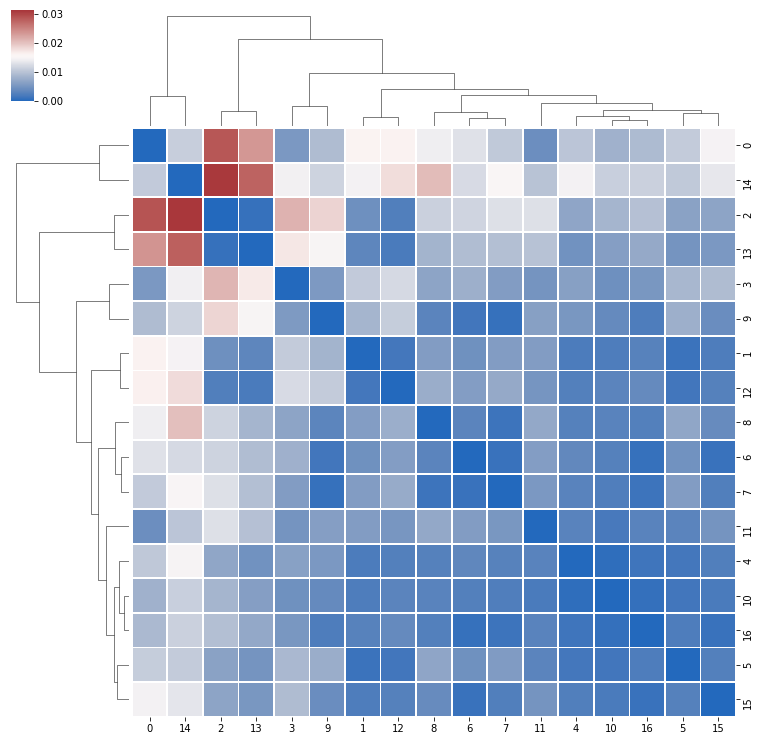

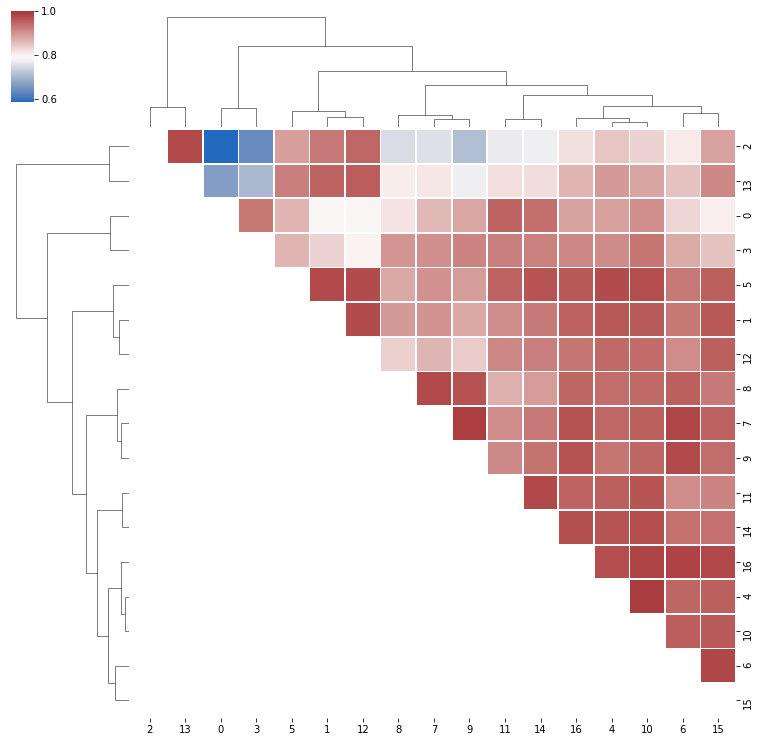

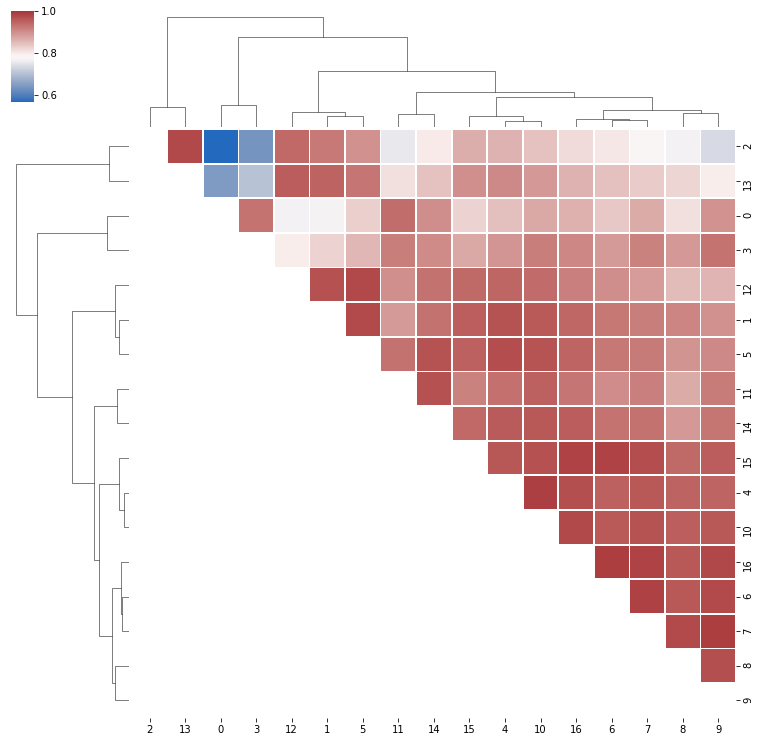

In [9]:
result_dir = "../results/"

def plot_correlationmatrix_dendogram(corr, img_name, method, ticks, div=False):

    df = pd.DataFrame(corr)
    
    # group the videos
    links = linkage(df, method=method,)
    order = leaves_list(links)
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)

    for i in range(nbVideos):
        for j in range(nbVideos):
            if i>=j:
                mask[order[i]][order[j]] = True
    
    if div:
        # the KL divergence is not symetric
        # div(x,y) is slightly different from div(y,x)
        sns.clustermap(df, cmap="vlag", method=method,
                   linewidths=.75, figsize=(13, 13), cbar_kws={"ticks":ticks})
    else:
        #the correlation is symetric so it's useless to print the bottom-left diagonal
        sns.clustermap(df, cmap="vlag", mask=mask, method=method,
                   linewidths=.75, figsize=(13, 13), cbar_kws={"ticks":ticks})
    
    plt.savefig(result_dir+img_name)
    plt.show()

method = 'ward'
plot_correlationmatrix_dendogram(divKL, "corrmatrix-dendo-KL-" + predDimension + ".pdf", method, [k/100 for k in range(5)], div=True)
plot_correlationmatrix_dendogram(corrPearson, "corrmatrix-dendo-Pearson-" + predDimension + ".pdf", method, [0.60,0.80,1])
plot_correlationmatrix_dendogram(corrSpearman, "corrmatrix-dendo-Spearman-" + predDimension + ".pdf", method, [0.60,0.80,1])

Good and bad examples of linear correlation between videos

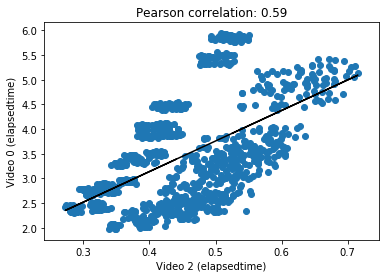

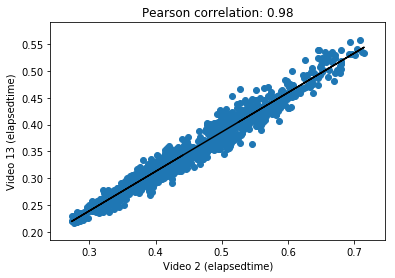

In [10]:
def plotCorrelationVideo(v1ID, v2ID,plot=True, filename=None):
    video1 = listVideo[v1ID][:]
    video2 = listVideo[v2ID][:]
    v1 = video1[predDimension]
    v2 = video2[predDimension]
    corr_pear_c = np.corrcoef(v1,v2)[0,1]
    
    if plot:
        fig = plt.figure()
        plt.scatter(v1,v2)   
        slope, intercept, r_value, p_value, std_err = stats.linregress(v1, v2)
        plt.plot(v1,slope*v1+intercept,color="black")   
        plt.xlabel("Video %d (%s)" % (v1ID, predDimension))
        plt.ylabel("Video %d (%s)" % (v2ID, predDimension))
        plt.title("Pearson correlation: " + str(round(corr_pear_c, 2)))
        if (filename is None): # default
            filename = "correlation-v" + str(v1ID) + "v" + str(v2ID) + ".pdf"
        fig.savefig(result_dir+filename, format="pdf", bbox_inches='tight')
    return corr_pear_c

if (predDimension == "elapsedtime"):
    # example (worst)
    v1ID = 2
    v2ID = 0
    # example (good)
    v1goodID = 2
    v2goodID = 13
    
    plotCorrelationVideo(v1ID, v2ID, plot=True)
    plotCorrelationVideo(v1goodID, v2goodID, plot=True)
    

Boxplot of video elapsedtime distributions

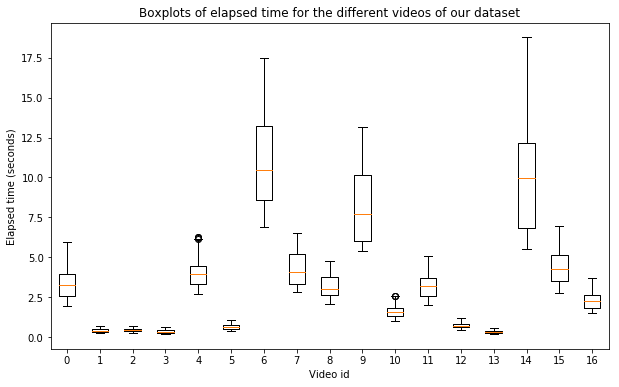

In [11]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

time = []

for i in range(nbVideos):
    time.append(listVideo[i][predDimension])

bp = ax.boxplot(time)
ax.set_xticklabels(range(nbVideos))

plt.title("Boxplots of elapsed time for the different videos of our dataset")
plt.ylabel("Elapsed time (seconds)")
plt.xlabel("Video id")

plt.show()
